In [1]:
import numpy as np 
import oxonfair
from oxonfair.utils import group_metrics as gm
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

In [87]:
def get_all_celeba_attributes():
    return ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips',
            'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby',
            'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male',
            'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
            'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair',
            'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
            'Wearing_Necktie', 'Young']

In [88]:
def gender_independent_attributes(): 
    return ['Bags_Under_Eyes', 'Bangs', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Chubby',
            'Eyeglasses', 'Gray_Hair', 'High_Cheekbones', 'Mouth_Slightly_Open', 'Narrow_Eyes',
            'Smiling', 'Wearing_Earrings', 'Wearing_Hat']

In [94]:
get_all_celeba_attributes().index(gender_independent_attributes()[0])

3

In [93]:
gender_independent_attributes()[0]

'Bags_Under_Eyes'

In [2]:
full_val = np.load('All_Attributes_outputs_val.npy')
full_test = np.load('All_Attributes_outputs_test.npy')

#full_val = np.load('resnet50_celeba/All_Attributes_Male_resnet50/resnet50_weights__outputs_val.npy')
#full_test = np.load('resnet50_celeba/All_Attributes_Male_resnet50/resnet50_weights__outputs_test.npy')

target_attribute = 'Wearing_Earrings' #can be like 'Smiling' or 'Wearing_Earrings' or 'Chubby'
#val=np.load('resnet50_celeba/' + target_attribute + '_Male_resnet50/' + target_attribute + '_resnet50_weights__outputs_val.npy')
val_target=np.load('resnet50_celeba/' + target_attribute + '_Male_resnet50/' + target_attribute + '_resnet50_weights__target_labels_val.npy')
val_groups=np.load('resnet50_celeba/' + target_attribute + '_Male_resnet50/' + target_attribute + '_resnet50_weights__protected_labels_val.npy')

#test=np.load('resnet50_celeba/' + target_attribute + '_Male_resnet50/' + target_attribute + '_resnet50_weights__outputs_test.npy')
test_target=np.load('resnet50_celeba/' + target_attribute + '_Male_resnet50/' + target_attribute + '_resnet50_weights__target_labels_test.npy')
test_groups=np.load('resnet50_celeba/' + target_attribute + '_Male_resnet50/' + target_attribute + '_resnet50_weights__protected_labels_test.npy')

#domain independent results (predicted result for the targer attribute)
DI_prediction = np.load('resnet50_celeba/DI_attribute_predictions/' + target_attribute + '_DI_sum_prob.npy')
#DI_prediction = np.load('resnet50_celeba/DI_max/' + target_attribute + '_DI_max.npy')

In [3]:
full_test[:,21]

array([ 3.68289566, -3.86832571,  4.57690334, ...,  5.62779093,
       -6.00241613, -2.22089195])

In [4]:
full_val.shape

(19867, 40)

In [5]:
full_test.shape

(19962, 40)

In [6]:
val = full_val[:, [34, 20]]
test = full_test[:, [34,20]]

In [7]:
from sklearn.metrics import accuracy_score, recall_score
DI_acc, DI_eo = (accuracy_score(test_target, DI_prediction),
np.abs(recall_score(test_target[test_groups==0],DI_prediction[test_groups==0])-recall_score(test_target[test_groups==1],DI_prediction[test_groups==1])))

In [80]:
from sklearn.metrics import confusion_matrix
TN, FP, FN, TP = confusion_matrix(test_target, DI_prediction, labels=[0, 1]).ravel()
#print(TN, FP, FN, TP)

In [84]:
DI_min_group_acc = np.minimum(TP / (1e-6 + TP + FN), TN / (1e-6 + TN + FP))

In [86]:
DI_acc, DI_eo, mimimum_DI_acc

(0.8881374611762348, 0.18829585327175996, 0.531636363507482)

In [9]:
accuracy_score(test_target, DI_prediction) # sanity check to see we've loaded the data correctly

0.8881374611762348

In [10]:
test_target.shape

(19962,)

In [11]:
test_groups.shape

(19962,)

In [12]:
#Helper functions.
#We assume that classifiers return multiple scores roughly lying in [0,1].
#To make this happen,we push logits through a sigmoid, and for square outputs we return them, and 1- them
def sigmoid(array):
    return np.stack ((1/(1+np.exp(array[:,0])),1/(1+np.exp(-array[:,0]))),1)
def square_align(array):
    return np.stack((array[:,1],1-array[:,1]),1)

In [13]:
val_dict={'data':val, 'target':val_target, 'groups':val_groups}
test_dict={'data':test,'target':test_target,'groups':test_groups}

In [14]:
fpred=oxonfair.FairPredictor(sigmoid,val_dict,inferred_groups=square_align, use_fast=False)

In [43]:
#fpred.fit(gm.accuracy,gm.equal_opportunity,0.005)
fpred.fit(gm.min_accuracy.min, gm.accuracy,0)

In [44]:
fpred.evaluate_groups(return_original=True)

accuracy  balanced_accuracy        f1       mcc  \
         groups                                                                
original Overall             0.924800           0.861855  0.794045  0.749278   
         0                   0.878429           0.852288  0.805169  0.717852   
         1                   0.987349           0.564036  0.207407  0.254912   
         Maximum difference  0.108920           0.288252  0.597762  0.462940   
updated  Overall             0.884633           0.886259  0.746123  0.688764   
         0                   0.860461           0.868403  0.804663  0.705642   
         1                   0.917238           0.871259  0.202733  0.289807   
         Maximum difference  0.056777           0.002856  0.601929  0.415834   

                             precision    recall   roc_auc    count  \
         groups                                                       
original Overall              0.831169  0.760095  0.965498  19867.0   
         0                    0.833624  0.778593  0.940365  11409.0   
         1                    0.518518  0.129630  0.960154   8458.0   
         Maximum difference   0.315106  0.648963  0.019789   2951.0   
updated  Overall              0.642871  0.888889  0.918004  19867.0   
         0                    0.733721  0.890791  0.940251  11409.0   
         1                    0.115584  0.824074  0.907260   8458.0   
         Maximum difference   0.618137  0.066716  0.032991   2951.0   

                             pos_data_count  neg_data_count  pos_data_rate  \
         groups                                                              
original Overall                     3789.0         16078.0       0.190718   
         0                           3681.0          7728.0       0.322640   
         1                            108.0          8350.0       0.012769   
         Maximum difference          3573.0           622.0       0.309871   
updated  Overall                     3789.0         16078.0       0.190718   
         0                           3681.0          7728.0       0.322640   
         1                            108.0          8350.0       0.012769   
         Maximum difference          3573.0           622.0       0.309871   

                             pos_pred_rate  
         groups                             
original Overall                  0.174410  
         0                        0.301341  
         1                        0.003192  
         Maximum difference       0.298149  
updated  Overall                  0.263704  
         0                        0.391708  
         1                        0.091038  
         Maximum difference       0.300670

In [67]:
df = fpred.evaluate_groups(test_dict,return_original=True)

In [70]:
df.accuracy.iloc[1]

0.8664979178574345

(19867, 2) (19867,) (19867,) (19867, 2)


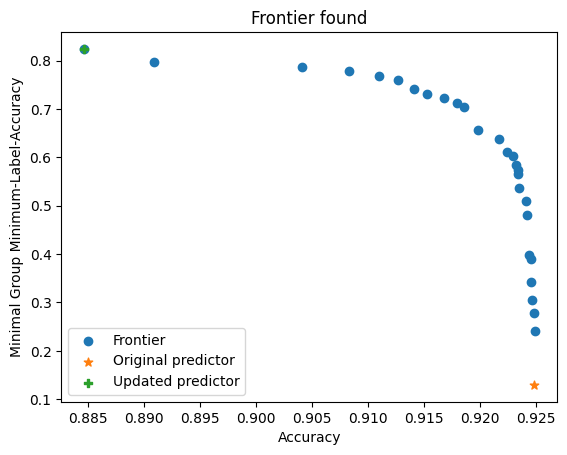

In [46]:
fpred.plot_frontier()
#plt.ylim(bottom=0.9)

In [56]:
fpred.evaluate(test_dict)

,original,updated
accuracy,0.910380,0.865545
balanced_accuracy,0.853250,0.874117
f1,0.777072,0.732029
mcc,0.721488,0.664245
precision,0.799487,0.622305
recall,0.755879,0.888727
roc_auc,0.956715,0.915420


(19962, 2) (19962,) (19962,) (19962, 2)


TypeError: 'NoneType' object is not subscriptable

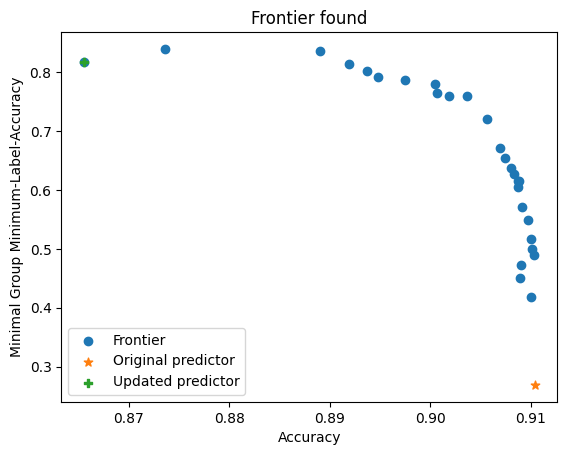

In [64]:
fpred.plot_frontier(test_dict)

(19962, 2) (19962,) (19962,) (19962, 2)


Text(0.5, 1.0, 'Frontier Found --- Attribute: Wearing_Earrings')

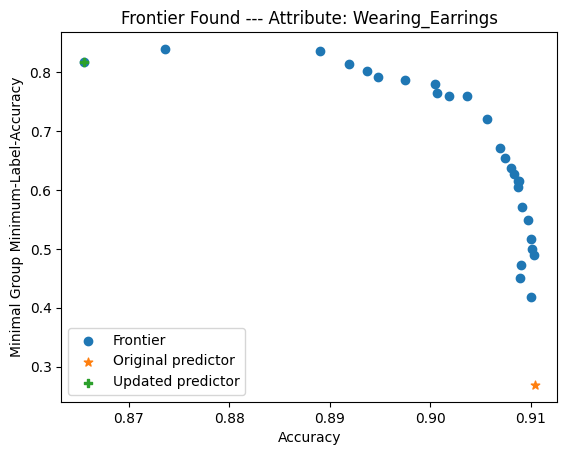

In [55]:
fpred.plot_frontier(test_dict)
plt.legend()
plt.title('Frontier Found --- Attribute: ' + target_attribute)

In [ ]:
fpred.plot_frontier(test_dict)
#plt.scatter(DI_eo,DI_acc,marker='s', facecolors='black', edgecolors='black', label='Domain Independent')
plt.legend()
plt.title('Frontier Found --- Attribute: ' + target_attribute)
#plt.ylim(bottom=0.9)

In [75]:
fpred.evaluate(metrics={'min_acc':gm.min_accuracy.min,'accuracy':gm.accuracy})

,original,updated
min_acc,0.12963,0.824074
accuracy,0.92480,0.884633


In [74]:
gm.min_accuracy.min()

Group metrics can take either one broadcast array or three broadcast array


IndexError: tuple index out of range

In [20]:
def findSubarray(a, k): #used to find the maximum contigious subarray of length k in the explanation weight vector
    
    n = len(a) #the length of the array a. 
    
    vec=[] 

    # Iterate to find all the sub-arrays 
    for i in range(n-k+1): 
        temp=[] 

        # Store the sub-array elements in the array 
        for j in range(i,i+k): 
            temp.append(a[j]) 

        # Push the vector in the container 
        vec.append(temp) 

    sum_arr = []
    for v in vec:
        sum_arr.append(np.sum(v)) # compute the sum of the values and store

    return (vec[np.argmax(sum_arr)]) #returns the array with the maximimum sum. 

In [21]:
example = [-1,2,3.5, 4, -1, -6, 7, 4, 3, 2, 12, -1]

In [22]:
findSubarray(a=example, k=3)

[3, 2, 12]